In [1]:
%load_ext autoreload
%autoreload 2
from geometricMultiGrid1D import *
from constructions import *
from plt_utils import *
from scipy.sparse import diags
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from scipy.linalg import norm

# test relax

In [2]:
def test_relax_solving(relax,n,iterations):
    A = diags([-1, 4, -1], [-1, 0, 1], shape=(n, n))
    f = np.array(range(n))
    u =  np.zeros(n)
    for _ in range(iterations):
        u = relax(A, f, u)
    usol = spsolve(A,f) 
    plt_vecs([u-usol,u],["error","sol"])

def test_relax_smoothing(relax,n,iterations):
    A = diags([-1, 4, -1], [-1, 0, 1], shape=(n, n))
    f = np.array(range(n))
    usol = spsolve(A,f) 
    u =  20*wave_basis_1D(n+1,n//2)
    errors = [u-usol]
    for _ in range(iterations):
        u = relax(A, f, u)
        errors.append(u-usol)
    plt_vecs(errors,["error"]*len(errors))

omega = 2/3
test_relax_solving(partial(wjacobi,omega=omega),n=20,iterations=60)
test_relax_smoothing(partial(wjacobi,omega=omega),n=20,iterations=60)


C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function plt_utils.plt_vecs.<locals>.tmp(i)>

interactive(children=(IntSlider(value=0, description='i', max=60), Output()), _dom_classes=('widget-interact',…

<function plt_utils.plt_vecs.<locals>.tmp(i)>

# test interpolate and restrict

In [3]:
import numpy as np
def test_recursive_restriction(k,v,restrict):
    vecs= [v]
    for _ in range(k):
        try:
            v = restrict(v)
        except:
            break
        vecs.append(v)
    plt_vecs(vecs)

test_recursive_restriction(7,wave_basis_1D(2**8,5),simple_restrict)


interactive(children=(IntSlider(value=0, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

<function plt_utils.plt_vecs.<locals>.tmp(i)>

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<function plt_utils.plt_vecs.<locals>.tmp(i)>

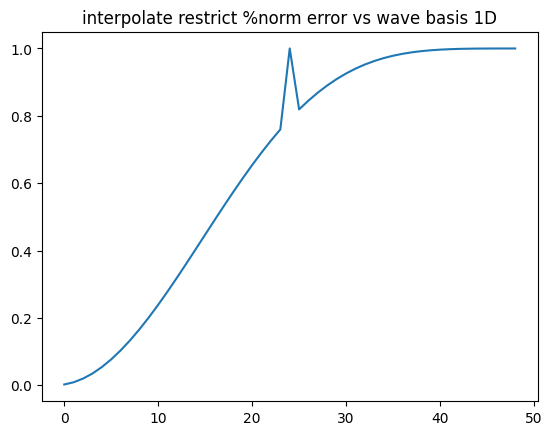

In [4]:
def test_interpolate_restrict_error(n,interpolate,restrict):
    wbasis_1D = [wave_basis_1D(n,k) for k in range(n)]
    vecs = [interpolate(restrict(v))-v for v in wbasis_1D ]
    norms = [norm(v)/norm(w) for v,w in zip(vecs,wbasis_1D) if norm(w)>0 ]  
    plt_vecs(vecs,["interpolate restrict error"]*len(vecs))
    plt.plot(range(len(norms)),norms)
    plt.title("interpolate restrict %norm error vs wave basis 1D")
    plt.show()

test_interpolate_restrict_error(50,simple_interpolate,simple_restrict)

# test Vcycles

In [5]:
from functools import lru_cache
def laplace_test(n=32,iterations=1,recursion_depth=3):
    A = helmholtz1D(n,0)
    u_exact = wave_basis_1D(n,1)
    f = A @ u_exact 
    # plt_vec(f)
    u_approx = np.zeros(n-1)

    errors = [u_exact-u_approx] 
    # Solve using the V-cycle method
    for _ in range(iterations):
        u_approx = geoVcycle1D(
            mat = lru_cache(recursion_depth*2)(partial(helmholtz1D,sigma=0)), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= 2/3), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    plt_vecs(errors,[f"errors after {j} vcycles" for j in range(len(errors))]) 
    
laplace_test(2**8,5,7)

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function plt_utils.plt_vecs.<locals>.tmp(i)>